In [1]:
%pylab inline
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import scanpy as sc
import pandas as pd
import torch
import scipy
import time
from sklearn.neighbors import RadiusNeighborsTransformer

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
sc.settings.figdir = '../result_TSK/'

In [3]:
stadata2 = sc.read_h5ad('cSCC/processed/stP10rep2.h5ad')
sc.pp.normalize_total(stadata2)
sc.pp.log1p(stadata2)
stdata2 = pd.DataFrame(stadata2.X,index=stadata2.obs_names,columns=stadata2.var_names)

stadata3 = sc.read_h5ad('cSCC/processed/stP10rep3.h5ad')
sc.pp.normalize_total(stadata3)
sc.pp.log1p(stadata3)
stdata3 = pd.DataFrame(stadata3.X,index=stadata3.obs_names,columns=stadata3.var_names)

In [4]:
scadata = sc.read_h5ad('cSCC/processed/scP10.h5ad')
stadata = sc.read_h5ad('cSCC/processed/stP10rep1.h5ad')

sc.pp.normalize_total(scadata)
sc.pp.log1p(scadata)

sc.pp.normalize_total(stadata)
sc.pp.log1p(stadata)

scdata = pd.DataFrame(scadata.X,index=scadata.obs_names,columns=scadata.var_names)
stdata = pd.DataFrame(stadata.X,index=stadata.obs_names,columns=stadata.var_names)

In [5]:
seed_value=42
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

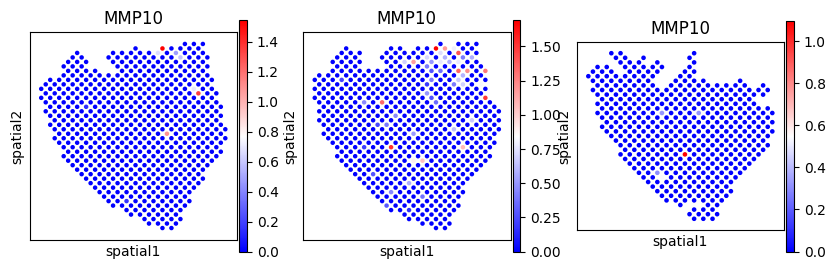

In [6]:
fig, ax = plt.subplots(1,3, figsize=(10,3))
sc.pl.spatial(stadata,  color=['MMP10'], spot_size=1,cmap='bwr',ax=ax[0],show=False)
sc.pl.spatial(stadata2, color=['MMP10'], spot_size=1,cmap='bwr',ax=ax[1],show=False)
sc.pl.spatial(stadata3, color=['MMP10'], spot_size=1,cmap='bwr',ax=ax[2],show=False)
plt.show()

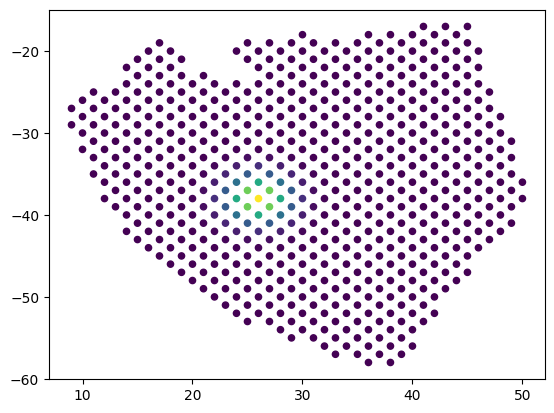

In [7]:
spcoor = stadata.obsm['spatial']
st_neighbor = scipy.spatial.distance.cdist(spcoor,spcoor)
sigma = 2
st_neighbor = np.exp(-st_neighbor**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)
plt.scatter(spcoor[:,0],-spcoor[:,1],c=st_neighbor[200,:],s=20)

In [8]:
sc.pp.calculate_qc_metrics(scadata,percent_top=None, log1p=False, inplace=True)
scadata.obs['n_genes_by_counts'].median()

sc.pp.calculate_qc_metrics(stadata,percent_top=None, log1p=False, inplace=True)
stadata.obs['n_genes_by_counts'].median()

sc.pp.calculate_qc_metrics(stadata2,percent_top=None, log1p=False, inplace=True)
stadata2.obs['n_genes_by_counts'].median()

sc.pp.calculate_qc_metrics(stadata3,percent_top=None, log1p=False, inplace=True)
stadata3.obs['n_genes_by_counts'].median()

102.5

In [9]:
1 - scadata.obs['n_genes_by_counts'].median()/stadata.obs['n_genes_by_counts'].median()

1 - scadata.obs['n_genes_by_counts'].median()/stadata.obs['n_genes_by_counts'].median()

-4.819672131147541

In [10]:
from torch.utils.data import DataLoader, Dataset
class STData(Dataset):
    def __init__(self,data,coord):
        self.data = data
        self.coord = coord

    def __getitem__(self, index):
        return self.data[index], self.coord[index]
    
    def __len__(self):
        return self.data.shape[0]

class SCData(Dataset):
    def __init__(self,data):
        self.data = data

    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return self.data.shape[0]

In [11]:
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
class FeatureNet(nn.Module):
    def __init__(self, n_genes, n_embedding=[512,256,128]):
        super(FeatureNet, self).__init__()

        self.fc1 = nn.Linear(n_genes, n_embedding[0])
        self.bn1 = nn.LayerNorm(n_embedding[0])
        self.fc2 = nn.Linear(n_embedding[0], n_embedding[1])
        self.bn2 = nn.LayerNorm(n_embedding[1])
        self.fc3 = nn.Linear(n_embedding[1], n_embedding[2])

    def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [12]:
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
class FeatureNet(nn.Module):
    def __init__(self, n_genes, n_embedding=[512,256,128]):
        super(FeatureNet, self).__init__()

        self.fc1 = nn.Linear(n_genes, n_embedding[0])
        self.bn1 = nn.LayerNorm(n_embedding[0])
        self.fc2 = nn.Linear(n_embedding[0], n_embedding[1])
        self.bn2 = nn.LayerNorm(n_embedding[1])
        self.fc3 = nn.Linear(n_embedding[1], n_embedding[2])
        
        ## 多加的
        self.dp = nn.Dropout(0)
        
    def forward(self, x,isdp = False):
        if isdp:
            x = self.dp(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [13]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch.optim.lr_scheduler as lr_scheduler
class BaseModel(nn.Module):
    def __init__(self, opt):
        super(BaseModel, self).__init__()
        self.opt = opt
        self.device = opt.device

        self.train_log = opt.outf + '/train.log'
        self.model_path = opt.outf + '/model.pth'
        if not os.path.exists(opt.outf):
            os.mkdir(opt.outf)
        self.best_acc_tgt = 0

        # print('source domain', self.domain_mask == 1)
        # print('target domain', self.domain_mask == 0)

        self.tsne = TSNE(n_components=2)
        self.pca = PCA(n_components=2)

    #         self.wgan = opt.wgan if opt.wgan is not None else False

    def set_requires_grad(self, nets, requires_grad=False):
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

            
        
    
    def forward(self):
        self.e_seq = self.netE(self.x_seq, self.t_seq)  # encoder of the data
        self.f_seq = self.netF(self.e_seq)  # logit of the prediction
        self.g_seq = torch.argmax(self.f_seq.detach(), dim=2)  # class of the prediction

    def optimize_parameters(self):
        self.forward()  # forward prediction
        # update the discriminator D (optional)
        self.set_requires_grad(self.netD, True)
        self.optimizer_D.zero_grad()
        self.backward_D()
        self.optimizer_D.step()

        # update the encoder E and predictor F
        self.set_requires_grad(self.netD, False)
        self.optimizer_G.zero_grad()
        self.backward_G()
        self.optimizer_G.step()

    def learn(self, epoch, dataloader):
        self.epoch = epoch

        self.train()

        loss_curve = {
            loss: []
            for loss in self.loss_names
        }
        acc_curve = []

        for data in dataloader:
            x_seq, y_seq = [d[0][None, :, :] for d in data], [d[1][None, :] for d in data]
            x_seq = torch.cat(x_seq, 0).to(self.device)
            y_seq = torch.cat(y_seq, 0).to(self.device)

            self.set_input(input=(x_seq, y_seq))
            self.optimize_parameters()

            for loss in self.loss_names:
                loss_curve[loss].append(getattr(self, 'loss_' + loss).item())

            acc_curve.append(self.g_seq.eq(self.y_seq).to(torch.float).mean(-1, keepdim=True))

        loss_msg = '[Train][{}] Loss:'.format(epoch)
        for loss in self.loss_names:
            loss_msg += ' {} {:.3f}'.format(loss, np.mean(loss_curve[loss]))

        acc = to_np(torch.cat(acc_curve, 1).mean(-1))
        acc_msg = '[Train][{}] Accuracy: total average {:.1f}, in each domain {}'.format(epoch, acc.mean() * 100, np.around(acc * 100, decimals=1))

        if (epoch + 1) % 10 == 0:
            print(loss_msg)
            print(acc_msg)
        with open(self.train_log, 'a') as f:
            f.write(loss_msg + "\n" + acc_msg + "\n")
        for lr_scheduler in self.lr_schedulers:
            lr_scheduler.step()

    def save(self):
        torch.save(self.state_dict(), self.model_path)

    def load(self):
        print('===> Loading model from {}'.format(self.model_path))
        try:
            self.load_state_dict(torch.load(self.model_path))
            print('<=== Success!')
        except:
            print('<==== Failed!')

    def set_data_stats(self, dm, ds):
        self.data_m, self.data_s = dm, ds

    def init_weight(self, net=None):
        if net is None:
            net = self
        for m in net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.01)
#                 nn.init.normal_(m.weight, mean=0, std=0.1)
#                 nn.init.xavier_normal_(m.weight, gain=10)
                nn.init.constant_(m.bias, val=0)

In [14]:
import torch
import torch.nn as nn
class MMDLoss(nn.Module):
    def __init__(self, kernel_type='rbf', kernel_mul=2.0, kernel_num=5, fix_sigma=None, **kwargs):
        super(MMDLoss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        self.kernel_type = kernel_type

    def guassian_kernel(self, source, target, kernel_mul, kernel_num, fix_sigma):
        n_samples = int(source.size()[0]) + int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        total0 = total.unsqueeze(0).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2)
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i)
                          for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp)
                      for bandwidth_temp in bandwidth_list]
        tmp = 0
        for x in kernel_val:
            tmp += x
        return tmp
#         print(kernel_val.shape)
#         return kernel_val
    

    def linear_mmd2(self, f_of_X, f_of_Y):
        loss = 0.0
        delta = f_of_X.float().mean(0) - f_of_Y.float().mean(0)
        loss = delta.dot(delta.T)
        return loss

    def forward(self, source, target):
        if self.kernel_type == 'linear':
            return self.linear_mmd2(source, target)
        elif self.kernel_type == 'rbf':
            batch_size = int(source.size()[0])
            kernels = self.guassian_kernel(
                source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
            XX = torch.mean(kernels[:batch_size, :batch_size])
            YY = torch.mean(kernels[batch_size:, batch_size:])
            XY = torch.mean(kernels[:batch_size, batch_size:])
            YX = torch.mean(kernels[batch_size:, :batch_size])
            loss = torch.mean(XX + YY - XY - YX)
            return loss

In [15]:
class SOmodel(BaseModel):
    def __init__(self, opt):
        super(SOmodel, self).__init__(opt)
        self.netE = FeatureNet(opt.n_genes)
        self.optimizer_G = torch.optim.AdamW(self.netE.parameters(), lr=opt.lr)
        self.lr_scheduler = lr_scheduler.StepLR(optimizer=self.optimizer_G,step_size=200, gamma=0.5)
        self.loss_names = ['E','E_pred','E_circle','E_mmd']
        self.mmd_fn = MMDLoss()
        self.sigma = opt.sigma
        self.alpha = opt.alpha
        self.verbose = opt.verbose
        
        
    def train_onestep(self,stdata,scdata,coord,ratio):
        if self.sigma == 0:
            self.nettrue = torch.eye(coord.shape[0])
        else:
            self.nettrue = torch.tensor(scipy.spatial.distance.cdist(coord,coord)).to(torch.float32)
            sigma = self.sigma
            self.nettrue = torch.exp(-self.nettrue**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)
            self.nettrue = F.normalize(self.nettrue,p=1,dim=1)
        self.nettrue = self.nettrue.to(self.device)
        stdata = stdata.to(self.device)
        scdata = scdata.to(self.device)
                
        self.e_seq_st = self.netE(stdata,True)
        self.e_seq_sc = self.netE(scdata,False)
        
        
        self.optimizer_G.zero_grad()
        
        self.netpred = self.e_seq_st.mm(self.e_seq_st.t())
        self.st2sc = F.softmax(self.e_seq_st.mm(self.e_seq_sc.t()),dim=1)
        self.sc2st = F.softmax(self.e_seq_sc.mm(self.e_seq_st.t()),dim=1)
        
        self.st2st = torch.log(self.st2sc.mm(self.sc2st)+1e-7)
        
        self.loss_E_pred = F.cross_entropy(self.netpred, self.nettrue,reduction='mean')
        
        self.loss_E_circle = F.kl_div(self.st2st,self.nettrue,reduction='none').sum(1).mean()
        
        ranidx = np.random.randint(0,self.e_seq_sc.shape[0],1000)
#         self.loss_E_mmd = torch.tensor(0)
        
        self.loss_E_mmd = self.mmd_fn(self.e_seq_st,self.e_seq_sc[ranidx])
        
        self.loss_E = self.loss_E_pred + self.alpha*self.loss_E_mmd + ratio*self.loss_E_circle
#         self.loss_E = self.loss_E_pred + self.alpha*ratio*self.loss_E_circle
        
        self.loss_E.backward()
        self.optimizer_G.step()
        
    def togpu(self):
        self.netE.to(self.device)

    def modeleval(self):
        self.netE.eval()
        
    def train(self,epoch,scdataloader,stdata,coord):
        with open(self.train_log, 'a') as f:
            localtime = time.asctime( time.localtime(time.time()) )
            f.write(localtime+'\n')
        
        loss_curve = {
            loss: []
            for loss in self.loss_names
        }
        for i in range(epoch):
            self.netE.train()
            for batch_idx, (scdata) in enumerate(scdataloader):
                scdata = scdata.to(torch.float32)
#                 ridx = np.random.randint(0,stdata.shape[0],scdata.shape[0])
#                 train_stdata = stdata[ridx,:]
                self.train_onestep(stdata,scdata,coord,max((i-50)/(epoch-50),0))   
                for loss in self.loss_names:
                    loss_curve[loss].append(getattr(self, 'loss_' + loss).item())
                    
            self.lr_scheduler.step()
            loss_msg = '[Train][{}] Loss:'.format(i+1)
            for loss in self.loss_names:
                loss_msg += ' {} {:.3f}'.format(loss, loss_curve[loss][-1])
            if (i + 1) % 1 == 0:
                print(loss_msg)
                print(self.lr_scheduler.get_last_lr())
            with open(self.train_log, 'a') as f:
                f.write(loss_msg + "\n")
        return loss_curve
    
    
    def train_spatialbatch(self,epoch,scdata,stdataloader):
        with open(self.train_log, 'a') as f:
            localtime = time.asctime( time.localtime(time.time()) )
            f.write(localtime+'\n')
        
        loss_curve = {
            loss: []
            for loss in self.loss_names
        }
        for i in range(epoch):
            self.netE.train()
            self.netD.train()
            for batch_idx, (stdata,coord) in enumerate(stdataloader):
                stdata = stdata.to(torch.float32)
                self.train_onestep(stdata,scdata,coord,max((i-50)/(epoch-50),0))   
                for loss in self.loss_names:
                    loss_curve[loss].append(getattr(self, 'loss_' + loss).item())
                    
            for lr_scheduler in self.lr_schedulers:
                lr_scheduler.step()
            loss_msg = '[Train][{}] Loss:'.format(i+1)
            for loss in self.loss_names:
                loss_msg += ' {} {:.3f}'.format(loss, loss_curve[loss][-1])
            if (i + 1) % 1 == 0:
                print(loss_msg)
                print(self.lr_scheduler_D.get_last_lr(),self.lr_scheduler_G.get_last_lr())
            with open(self.train_log, 'a') as f:
                f.write(loss_msg + "\n")
        return loss_curve
    
    def train_wholedata(self,epoch,scdata,stdata,coord):
        with open(self.train_log, 'a') as f:
            localtime = time.asctime( time.localtime(time.time()) )
            f.write(localtime+'\n')
        
        loss_curve = {
            loss: []
            for loss in self.loss_names
        }
        for i in range(epoch):
            self.netE.train()
            scdata = scdata.to(torch.float32)
            if isinstance(stdata,list):
                shuffle_list = randint(0,len(stdata),len(stdata))
                for idx in shuffle_list:
                    self.train_onestep(stdata[idx],scdata,coord[idx],max((i-50)/(epoch-50),0))
            else:
                self.train_onestep(stdata,scdata,coord,max((i-50)/(epoch-50),0)) 
            
            for loss in self.loss_names:
                loss_curve[loss].append(getattr(self, 'loss_' + loss).item())
                    
            self.lr_scheduler.step()
            loss_msg = '[Train][{}] Loss:'.format(i)
            for loss in self.loss_names:
                loss_msg += ' {} {:.3f}'.format(loss, loss_curve[loss][-1])
            if (i + 1) % 1 == 0:
                if self.verbose:
                    print(loss_msg)
                    print(self.lr_scheduler.get_last_lr())
            with open(self.train_log, 'a') as f:
                f.write(loss_msg + "\n")
        return loss_curve

In [16]:
class setting( object ):
    pass
opt= setting()
setattr(opt, 'device', 'cuda:0')
setattr(opt, 'outf', '../log/1009_cSCCP10_mmd')
setattr(opt, 'n_genes', stdata.shape[1])
setattr(opt, 'no_bn', False)
setattr(opt, 'lr', 0.002)
setattr(opt, 'sigma', 0.75)
setattr(opt, 'alpha', 0.8)
setattr(opt, 'verbose', True)

In [17]:
spcoor = pd.DataFrame(stadata.obsm['spatial'],index=stdata.index,columns=['xcoord','ycoord'])
spcoor2 = pd.DataFrame(stadata2.obsm['spatial'],index=stdata2.index,columns=['xcoord','ycoord'])
# spcoor3 = pd.DataFrame(stadata3.obsm['spatial'],index=stdata3.index,columns=['xcoord','ycoord'])

scdataset = SCData(data=scdata.values)
batch_size = 1024

In [18]:
spcoor3 = pd.DataFrame(stadata3.obsm['spatial'],index=stdata3.index,columns=['xcoord','ycoord'])

In [19]:
spcoor_list = [
    torch.tensor(spcoor.values).float(),
    torch.tensor(spcoor2.values).float(),
    # torch.tensor(spcoor3.values).float()
]

stdata_list = [
    torch.tensor(stdata.values).float(),
    torch.tensor(stdata2.values).float(),
#     torch.tensor(stdata3.values).float()
]

In [20]:
testmodel =  SOmodel(opt)
testmodel.togpu()
loss_curve = testmodel.train_wholedata(1000,torch.tensor(scdata.values).float(),stdata_list,spcoor_list)
# loss_curve = testmodel.train_spatialbatch(400,torch.tensor(scdata.values).float(),stdataloader)

[Train][0] Loss: E 6.674 E_pred 4.529 E_circle 6.742 E_mmd 2.681
[0.002]
[Train][1] Loss: E 6.117 E_pred 5.199 E_circle 7.302 E_mmd 1.148
[0.002]
[Train][2] Loss: E 5.004 E_pred 4.406 E_circle 5.257 E_mmd 0.747
[0.002]
[Train][3] Loss: E 4.492 E_pred 4.037 E_circle 5.229 E_mmd 0.570
[0.002]
[Train][4] Loss: E 4.857 E_pred 4.475 E_circle 5.049 E_mmd 0.478
[0.002]
[Train][5] Loss: E 4.502 E_pred 3.879 E_circle 5.600 E_mmd 0.779
[0.002]
[Train][6] Loss: E 3.858 E_pred 3.330 E_circle 5.396 E_mmd 0.660
[0.002]
[Train][7] Loss: E 3.486 E_pred 3.110 E_circle 4.896 E_mmd 0.469
[0.002]
[Train][8] Loss: E 3.176 E_pred 2.869 E_circle 4.682 E_mmd 0.384
[0.002]
[Train][9] Loss: E 3.818 E_pred 3.446 E_circle 4.660 E_mmd 0.465
[0.002]
[Train][10] Loss: E 3.554 E_pred 3.288 E_circle 4.864 E_mmd 0.332
[0.002]
[Train][11] Loss: E 2.778 E_pred 2.454 E_circle 4.511 E_mmd 0.406
[0.002]
[Train][12] Loss: E 2.616 E_pred 2.362 E_circle 4.318 E_mmd 0.317
[0.002]
[Train][13] Loss: E 2.445 E_pred 2.229 E_circle 

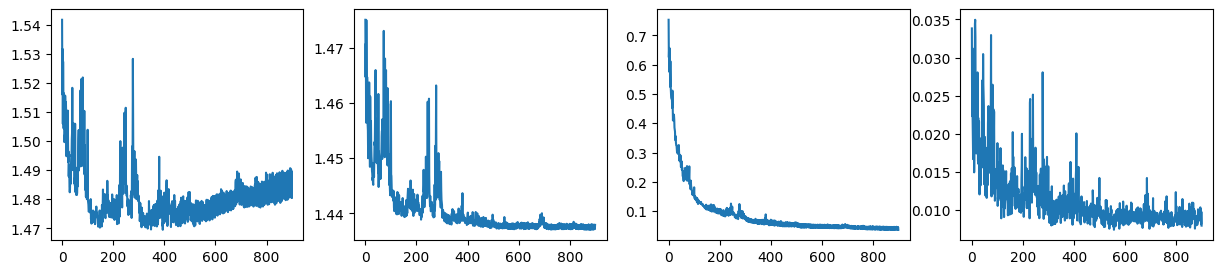

In [21]:
figsize(15,3)
skipidx =  100
N = len(loss_curve['E'])-skipidx
subplot(141)
plt.plot(np.arange(N),loss_curve['E'][skipidx:])
subplot(142)
plt.plot(np.arange(N),loss_curve['E_pred'][skipidx:])
subplot(143)
plt.plot(np.arange(N),loss_curve['E_circle'][skipidx:])
subplot(144)
plt.plot(np.arange(N),loss_curve['E_mmd'][skipidx:])

In [22]:
testmodel.save()

In [23]:
testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())
stembedding = testmodel.netE(torch.tensor(stdata.values,dtype=torch.float32).cuda())
netst2sc = F.softmax(stembedding.mm(scembedding.t()),dim=1).detach().cpu().numpy()
netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()
netst2sc = pd.DataFrame(netst2sc,index=stdata.index,columns=scdata.index)
netsc2st = pd.DataFrame(netsc2st,index=scdata.index,columns=stdata.index)

In [24]:
def all_coord(mappingmtx,spcoor):
    mappingnorm = mappingmtx.div(mappingmtx.sum(axis=1), axis=0)

    spaotsc_coord = np.zeros([mappingnorm.shape[0],2])
    spaotsc_coord[:,0] = np.matmul(mappingnorm.values,spcoor.xcoord.values)
    spaotsc_coord[:,1] = np.matmul(mappingnorm.values,spcoor.ycoord.values)
    return spaotsc_coord

def k_coord(mappingmtx,spcoor, k=1):
    maskmap = np.zeros_like(mappingmtx)

    argmask = np.argsort(1/(mappingmtx.values+1e-15),axis=1)

    for i in range(argmask.shape[0]):
        for j in range(k):
            maskmap[i,argmask[i,j]]=1

    mappingnorm = (maskmap*mappingmtx).div((maskmap*mappingmtx).sum(axis=1)+1e-15, axis=0)

    spaotsc_coord = np.zeros([mappingnorm.shape[0],2])
    spaotsc_coord[:,0] = np.matmul(mappingnorm.values,spcoor.xcoord.values)
    spaotsc_coord[:,1] = np.matmul(mappingnorm.values,spcoor.ycoord.values)
    return spaotsc_coord

scadata.obsm['spatialDA_rep1'] = all_coord(netsc2st,spcoor)

In [25]:
testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())
stembedding = testmodel.netE(torch.tensor(stdata2.values,dtype=torch.float32).cuda())
netst2sc = F.softmax(stembedding.mm(scembedding.t()),dim=1).detach().cpu().numpy()
netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()
netst2sc = pd.DataFrame(netst2sc,index=stdata2.index,columns=scdata.index)
netsc2st = pd.DataFrame(netsc2st,index=scdata.index,columns=stdata2.index)
scadata.obsm['spatialDA_rep2'] = all_coord(netsc2st,spcoor2)

In [26]:
# testmodel.modeleval()
# scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())
# stembedding = testmodel.netE(torch.tensor(stdata3.values,dtype=torch.float32).cuda())
# netst2sc = F.softmax(stembedding.mm(scembedding.t()),dim=1).detach().cpu().numpy()
# netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()
# netst2sc = pd.DataFrame(netst2sc,index=stdata3.index,columns=scdata.index)
# netsc2st = pd.DataFrame(netsc2st,index=scdata.index,columns=stdata3.index)
# scadata.obsm['spatialDA_rep3'] = all_coord(netsc2st,spcoor3)

In [27]:
print(scadata.obs['level1_celltype'].unique().tolist())

['Fibroblast', 'Epithelial', 'CLEC9A', 'CD1C', 'ASDC', 'B Cell', 'Mac', 'LC', 'Tcell', 'Melanocyte', 'Endothelial Cell', 'MDSC', 'PDC']


In [28]:
print(scadata.obs['level2_celltype'].unique().tolist())

['Fibroblast', 'Tumor_KC_Basal', 'CLEC9A', 'Keratinocyte', 'Tumor_KC_Diff', 'TSK', 'Tumor_KC_Cyc', 'CD1C', 'Pilosebaceous', 'ASDC', 'B Cell', 'Mac', 'LC', 'Tcell', 'Melanocyte', 'Endothelial Cell', 'MDSC', 'PDC', 'Eccrine']


In [29]:
scadata.obsm['spatialDA_repavg'] = (scadata.obsm['spatialDA_rep2']+scadata.obsm['spatialDA_rep1'])/2

In [30]:
scadata.obs['rough_celltype'] =scadata.obs['level1_celltype'].astype(str)
scadata.obs.loc[scadata.obs['level1_celltype']=='CLEC9A','rough_celltype'] = 'DC'
scadata.obs.loc[scadata.obs['level1_celltype']=='CD1C','rough_celltype'] = 'DC'
scadata.obs.loc[scadata.obs['level1_celltype']=='ASDC','rough_celltype'] = 'DC'
scadata.obs.loc[scadata.obs['level1_celltype']=='PDC','rough_celltype'] = 'PDC'
scadata.obs.loc[scadata.obs['level1_celltype']=='MDSC','rough_celltype'] = 'DC'
scadata.obs.loc[scadata.obs['level1_celltype']=='LC','rough_celltype'] = 'DC'
scadata.obs.loc[scadata.obs['level1_celltype']=='Mac','rough_celltype'] = 'Myeloid cell'
scadata.obs.loc[scadata.obs['level1_celltype']=='Tcell','rough_celltype'] = 'T cell'
scadata.obs.loc[scadata.obs['level3_celltype']=='Treg','rough_celltype'] = 'Treg'
scadata.obs.loc[scadata.obs['level2_celltype']=='TSK','rough_celltype'] = 'TSK'
scadata.obs.loc[scadata.obs['level3_celltype'].isin(['CD4_Naive', 'CD4_Pre_Exh','CD4_Exh']),'rough_celltype'] = 'T cell'
scadata.obs.loc[scadata.obs['level2_celltype'].isin(['Tumor_KC_Basal', 'Tumor_KC_Diff','Tumor_KC_Cyc']),'rough_celltype'] = 'NonTSK'

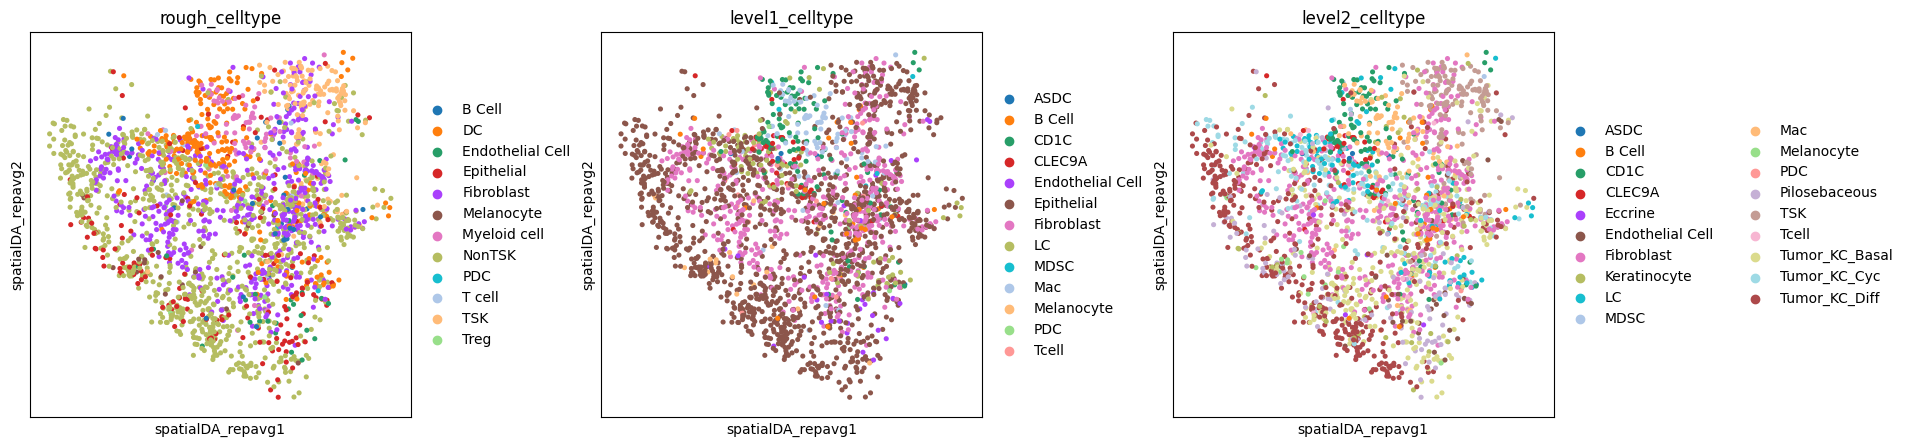

In [32]:
figsize(6,5)
sc.pl.spatial(scadata, color=['rough_celltype',"level1_celltype","level2_celltype"], spot_size=0.6,cmap='bwr',basis='spatialDA_repavg')

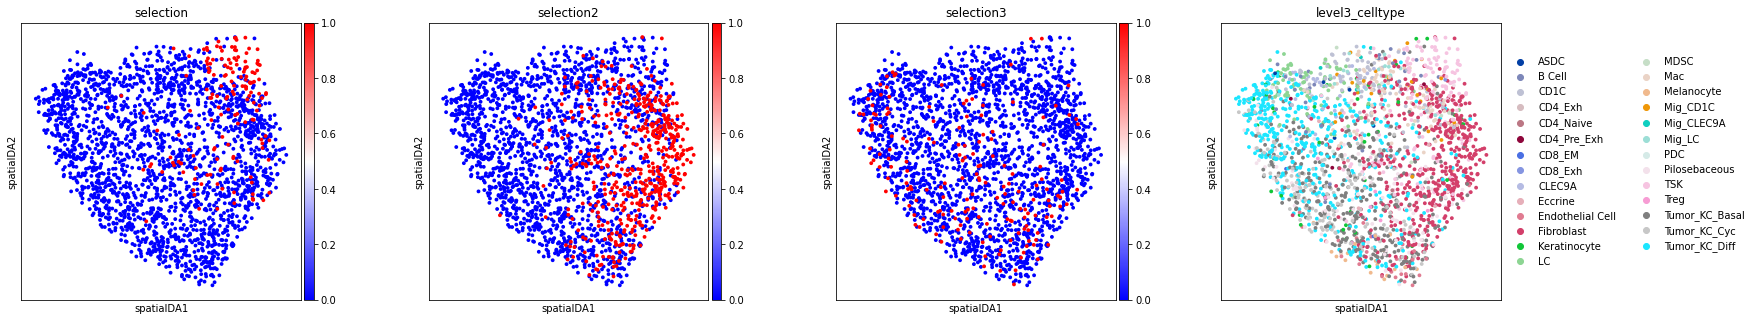

In [52]:
scadata.obs['selection'] = (scadata.obs['level2_celltype']=='TSK').astype(int)
scadata.obs['selection2'] = (scadata.obs['level1_celltype']=='Fibroblast').astype(int)
scadata.obs['selection3'] = (scadata.obs['rough_celltype']=='Epithelial').astype(int)

figsize(6,5)
sc.pl.spatial(scadata, color=['selection','selection2','selection3','level3_celltype'], spot_size=0.6,cmap='bwr',basis='spatialDA')

In [53]:
EpiTSKidx = scadata.obs_names[scadata.obs['level2_celltype']=='TSK'].tolist()
EpinonTSKidx = scadata.obs_names[(scadata.obs['level1_celltype']=='Epithelial')&(scadata.obs['level2_celltype']!='TSK')].tolist()

In [34]:
scadata.uns['rough_celltype_colors']=['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b', '#e377c2',  '#17becf', '#aec7e8', '#ffbb78', '#98df8a','#FF9896']

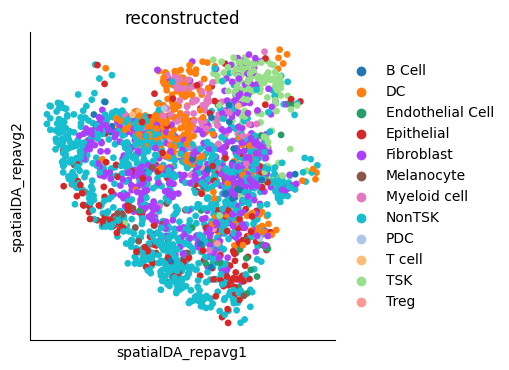

In [35]:
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
figsize(4,4)
sc.pl.spatial(scadata,color="rough_celltype",spot_size=1, show=True,basis='spatialDA_repavg',title='reconstructed')
#,save='AllP10' save='allreconstructed'

In [36]:
import colorbm as cbm

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


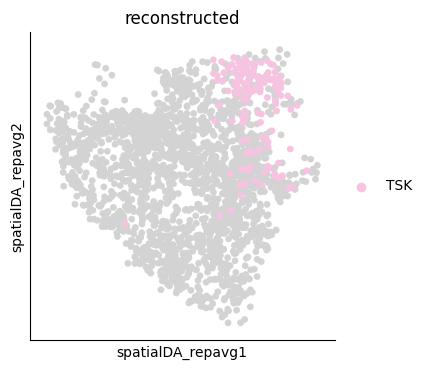

In [37]:
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
figsize(4,4)
sc.pl.spatial(scadata,color="level3_celltype",groups=["TSK"],spot_size=1, show=True,basis='spatialDA_repavg',title='reconstructed',na_in_legend=False)
#save='TSK',,save='P10TSK'

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


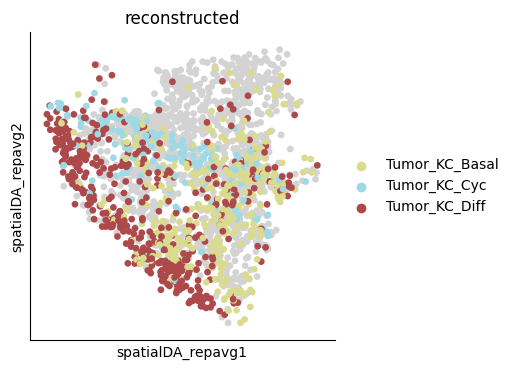

In [38]:
figsize(4,4)
sc.pl.spatial(scadata,color="level2_celltype",groups=['Tumor_KC_Cyc','Tumor_KC_Basal','Tumor_KC_Diff'],spot_size=1, 
              show=True,basis='spatialDA_repavg',title='reconstructed',na_in_legend=False,save='otherKC')
#save='nonTSK',

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


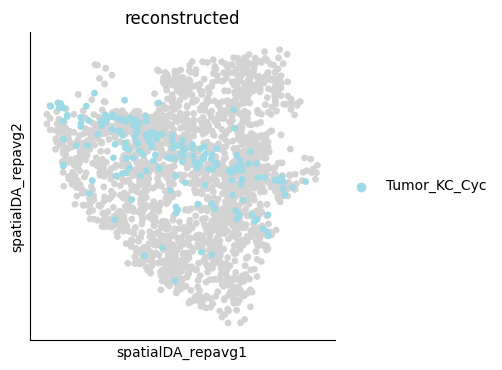

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


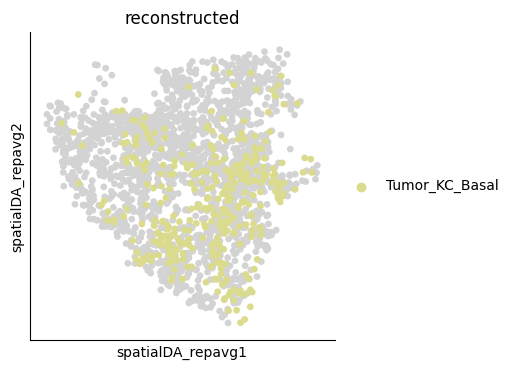

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


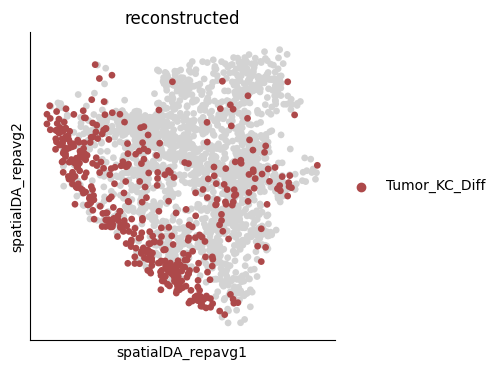

In [39]:
figsize(4,4)
sc.pl.spatial(scadata,color="level2_celltype",groups=["Tumor_KC_Cyc"],spot_size=1, show=True,basis='spatialDA_repavg',title='reconstructed',na_in_legend=False,save='P10cyc')
sc.pl.spatial(scadata,color="level2_celltype",groups=["Tumor_KC_Basal"],spot_size=1, show=True,basis='spatialDA_repavg',title='reconstructed',na_in_legend=False,save='P10bas')
sc.pl.spatial(scadata,color="level2_celltype",groups=["Tumor_KC_Diff"],spot_size=1, show=True,basis='spatialDA_repavg',title='reconstructed',na_in_legend=False,save='P10diff')
#save='nonTSK',

In [40]:
scadata.write_h5ad('../result_TSK/P10sc.adata')

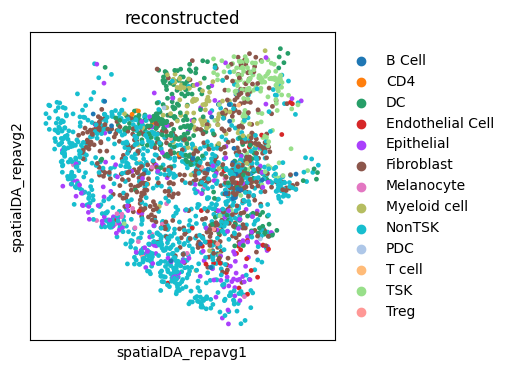

In [38]:
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
figsize(4,4)
sc.pl.spatial(scadata,color="rough_celltype",spot_size=0.7, show=True,basis='spatialDA_repavg',title='reconstructed')
#save='allreconstructed'

In [39]:
import squidpy as sq
sq.gr.spatial_neighbors(scadata,spatial_key='spatialDA_repavg')
sq.gr.nhood_enrichment(scadata,cluster_key='rough_celltype')
sq.gr.interaction_matrix(scadata,cluster_key='rough_celltype')

  0%|          | 0/1000 [00:00<?, ?/s]

In [42]:
kscadata = scadata[ scadata.obs.level2_celltype.isin(['Tumor_KC_Cyc','Tumor_KC_Basal','Tumor_KC_Diff','TSK'])].copy()
sq.gr.spatial_neighbors(kscadata,spatial_key='spatialDA_repavg')
sq.gr.nhood_enrichment(kscadata,cluster_key='level2_celltype')

  0%|          | 0/1000 [00:00<?, ?/s]

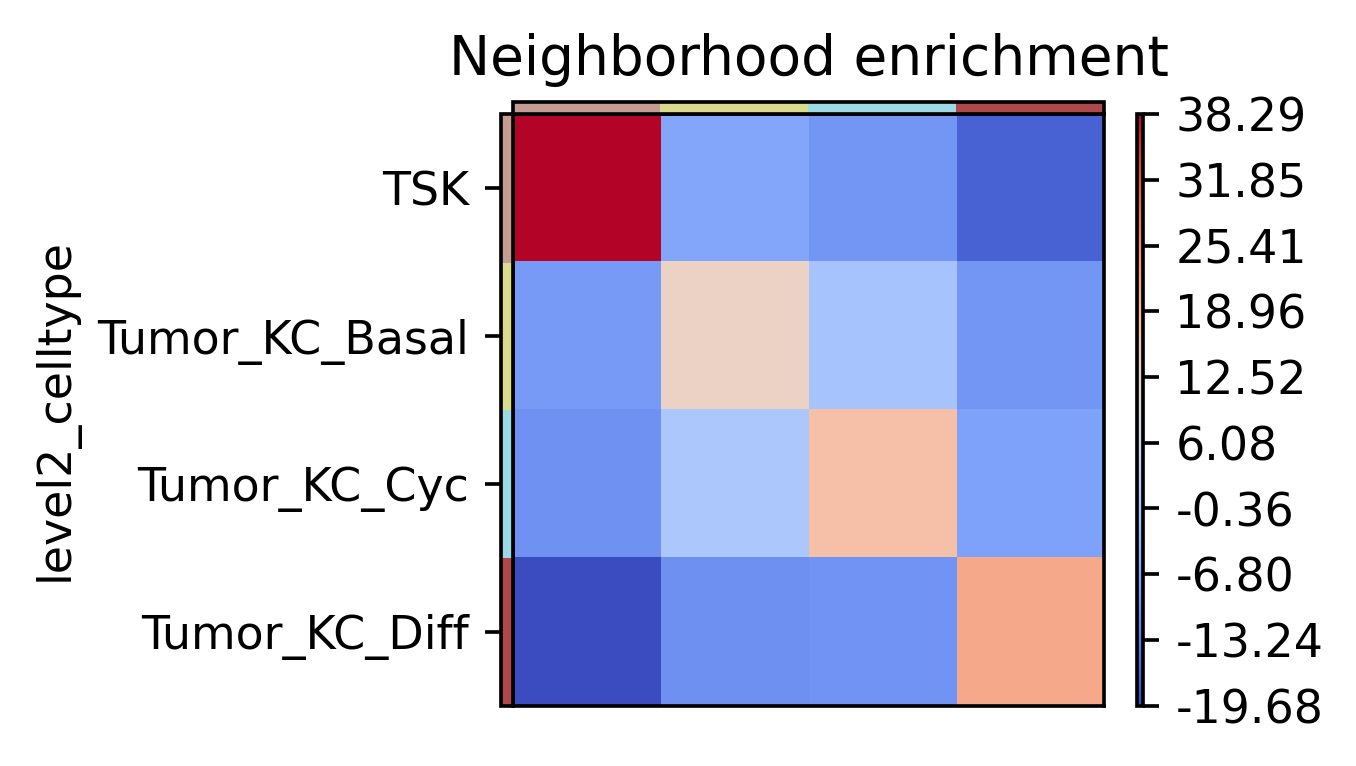

In [66]:
sc.settings.figdir = '../result_TSK/'
sq.pl.nhood_enrichment(kscadata, cluster_key="level2_celltype",cmap='coolwarm',dpi=330,save='P10_KC.pdf')

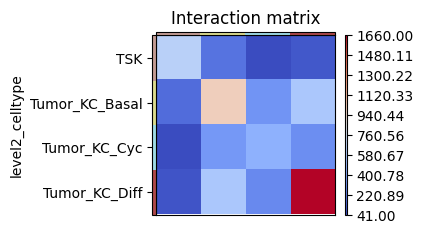

In [46]:
sq.gr.interaction_matrix(kscadata, cluster_key="level2_celltype")
sq.pl.interaction_matrix(kscadata, cluster_key="level2_celltype",cmap='coolwarm')

In [265]:
import squidpy as sq
sq.gr.spatial_neighbors(scadata, coord_type="generic",spatial_key='spatialDA')
sq.gr.nhood_enrichment(scadata, cluster_key="level1_celltype")
sq.pl.nhood_enrichment(scadata, cluster_key="level1_celltype", method="single", cmap="inferno")

In [86]:
mmdcoord.to_csv('mmdcoord.csv')

In [65]:
scembedding =  testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda()).detach().cpu().numpy()
stembedding =  testmodel.netE(torch.tensor(stdata.values,dtype=torch.float32).cuda()).detach().cpu().numpy()
stembedding2 = testmodel.netE(torch.tensor(stdata2.values,dtype=torch.float32).cuda()).detach().cpu().numpy()
stembedding3 = testmodel.netE(torch.tensor(stdata3.values,dtype=torch.float32).cuda()).detach().cpu().numpy()

In [66]:
np.savez('./cSCC/results/P10Embedding.npz',sc = scembedding, st1 = stembedding,st2 = stembedding2,st3 = stembedding3)